## 0. Get setup


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the scripts directory, download it from GitHub if it doesn't work
try:
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/vic-art/ViT_paper_replicating
    !mv ViT_paper_replicating/scripts .
    !rm -rf ViT_paper_replicating
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'ViT_paper_replicating'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 5), reused 21 (delta 3), pack-reused 0
Receiving objects: 100% (28/28), 15.19 MiB | 39.29 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [4]:
# Setup device egnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

We are trying to replicate the ViT architecture for FoodVision problem. 

To do so, we need some data.
We download the pizza, steak and sushi image dataset from GitHub with the help of `download_data()` function from `helper_functions.py`.


In [5]:
image_path = download_data(source="https://github.com/vic-art/ViT_paper_replicating/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/vic-art/ViT_paper_replicating/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Now we can turn the data into DataLoader's with the help of `create_dataloaders()` function in `data_setup.py`.

First, we'll create a transform to prepare images.
In Table 3, the training resolution is mentioned as being 224 (height=224, width=224).


In [8]:
from torchvision import transforms
from scripts import data_setup

# Create image size
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline 
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [9]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for small hardware... can always scale up latter)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

In [10]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

Let's get a single image and label from a batch of data and inspect their shapes.

In [15]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image shapes and label shape
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

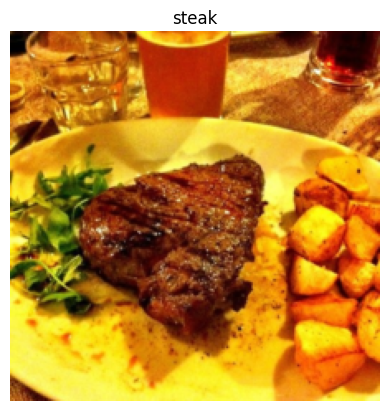

In [16]:
# Plot the image with matplot
plt.imshow(image.permute(1,2,0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);


## 3. Replicating ViT: Overview

* Inputs - What goes into model? (image tensors)
* Ouputs - What comes out of the model/layer/block? (we want the model to output image classification label)
* Layers - Takes an input, manipulates it with a function (for example, could be self-attention)
* Blocks - collection of layers.
* Model (architecture) - collection of blocks.

### 3.1 ViT Overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training. 

### Figure 1

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width = 600 alt="figure 1 from vision transformer paper" />

* Embedding = learnable representation (start with random numbers and improve overtime)



### Four equations 

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width = 600 alt="four equations from vision transformer paper" />

#### Section 3.1:

**Equation 1.**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1.**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos ]

```

---



**Equation 2&3.**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

The MLP contains two layers with a GELU non-linearity.

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

```

```python
# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```



**Equation 4.**
Similar to BERT's [class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP - multilayer perceptron = a neural network with X number of layers
* MLP - one hidden layer at training time
* MLP - single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4. 
y = Linear_layer(LN_layer(x_output_MLP_block))
```



### Table 1 

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width = 600 alt="table 1 from vision transformer paper" />

* ViT-Base, ViT-Large, ViT-Huge - are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers. 
* Hidden size $D$ - the embedding size throughout the architecture.
* MLP size - the number of hidden units/ neurons in MLP
* Head - the number of multi-head self-attention


## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = inputs -> functions -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: (196, 768)

### 4.1  Calculate input and output shapes by hand

> **Equation 1.**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1.**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$
* Output shape: ${N \times\left(P^2 \cdot C\right)}$
* H - height
* W - Width
* C - color channels
* P - patch size
* N - number of patches - (height*width) /p^2
* D - constant latent vector size - embedding dimension

We'll use a patch size (P) of 16 since it's the best performing version of ViT-Base uses (column "ViT-B/16" of Table 5 in the ViT paper).

In [17]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

Let's replicate the input and output shapes of the patch embedding layer.

In [18]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

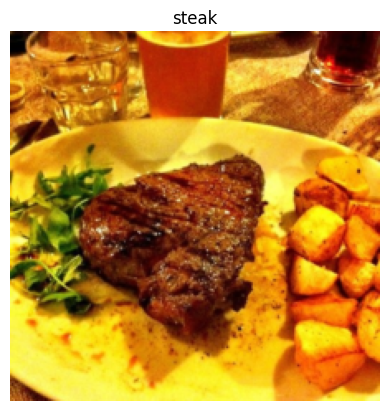

In [19]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
image.shape

torch.Size([3, 224, 224])

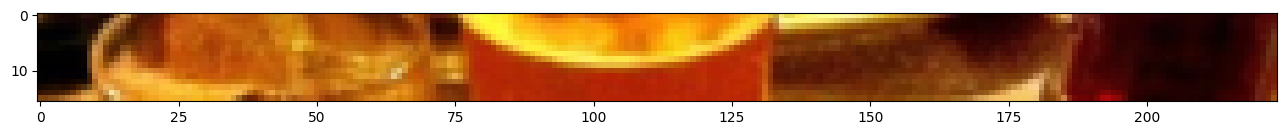

In [21]:
# Get the top row of the image
image_permuted = image.permute(1,2,0) # convert image to color channel last

# Index to plot top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


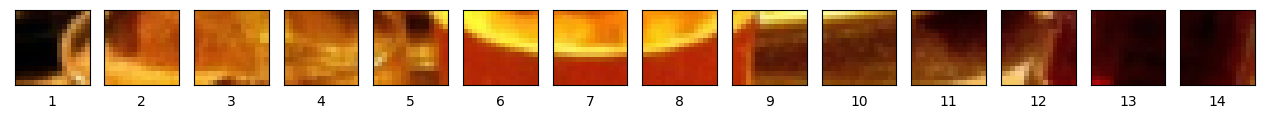

In [22]:
# Set up code to plot row as patches
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows = 1, 
                        ncols = img_size // patch_size, # one column for each patch
                        sharex = True,
                        sharey = True,
                        figsize = (patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0 
Number of patches per column: 14.0 
Total patches: 196.0 
Patch size: 16 pixels x 16 pixels


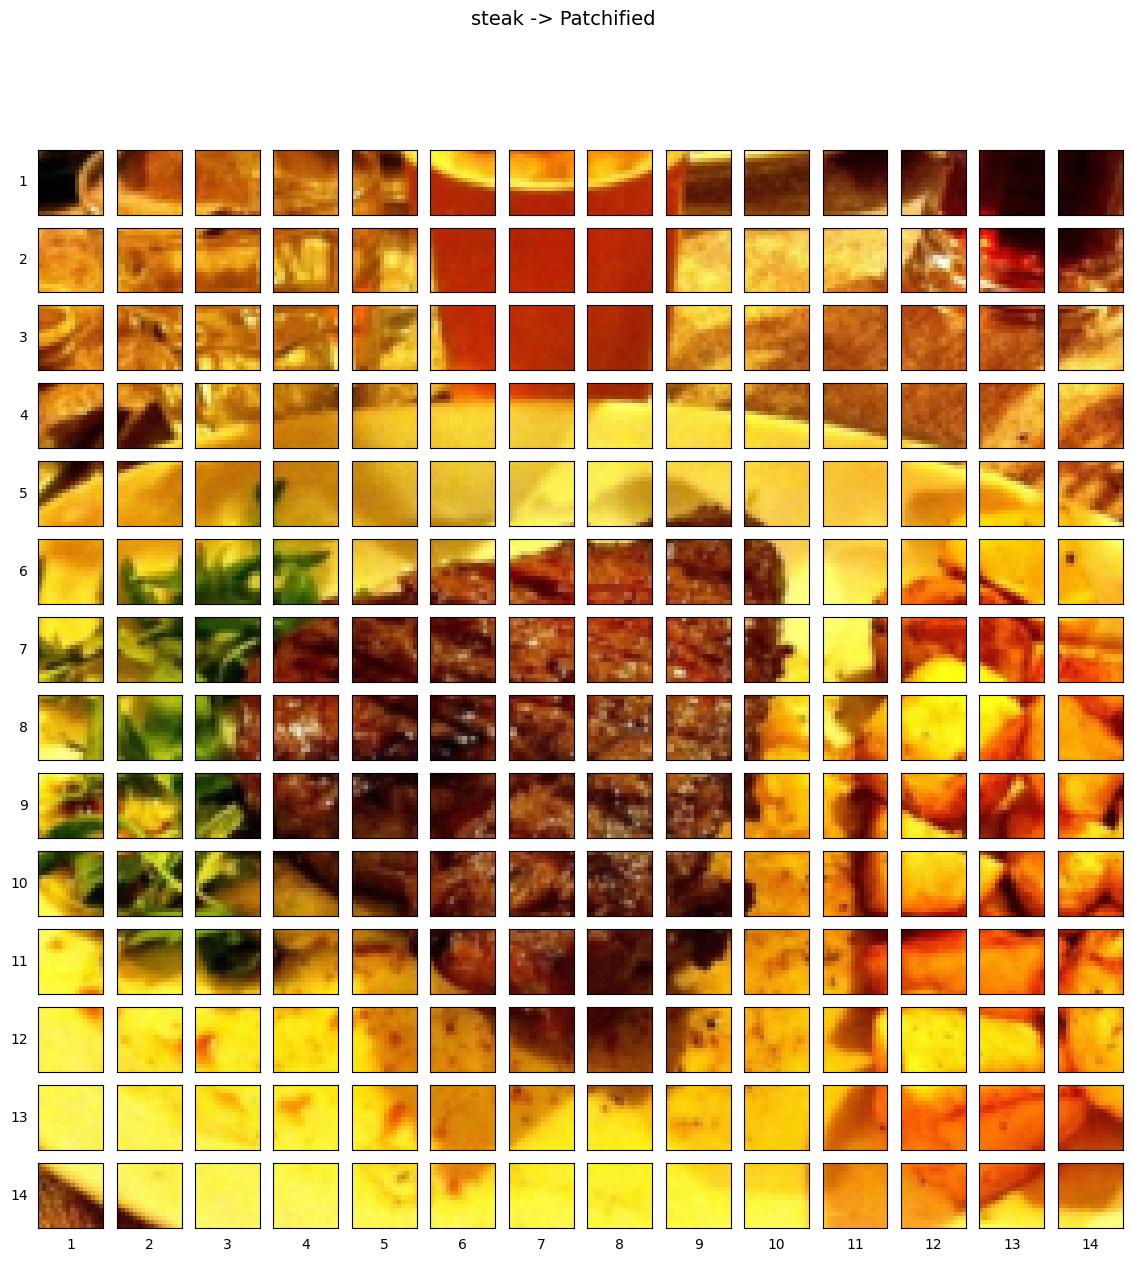

In [23]:
# Setup code to plot the whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
 \nNumber of patches per column: {num_patches}\
 \nTotal patches: {num_patches*num_patches}\
 \nPatch size: {patch_size} pixels x {patch_size} pixels")

 # Create a series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                         ncols = img_size // patch_size,
                         figsize = (num_patches, num_patches),
                         sharex = True,
                         sharey = True)
# There will be 196 axises in total (14*14)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axis
    axs[i, j].imshow(image_permuted[patch_height: patch_height + patch_size, # iterate through the height
                                    patch_width: patch_width + patch_size, # iterate through the width
                                    :]) # get all color channels 

    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1, 
                        rotation = "horizontal",
                        horizontalalignment = "right",
                        verticalalignment = "center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

### 4.3 Creating image patches and tuning them into patch embeddings 

We can create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`. 
We can recreate these with:
* `torch.nn.Conv2d()` for turning the image into patches of CNN feature maps.
* `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

In [24]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn 

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels = 3, # for color images
                   out_channels = 768, # D size from Table 1 for ViT-Base, embedding size
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

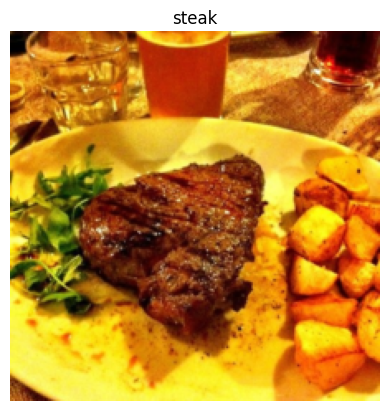

In [25]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [27]:
# Pass the image though the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

---



```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [223, 375, 85, 476, 292]


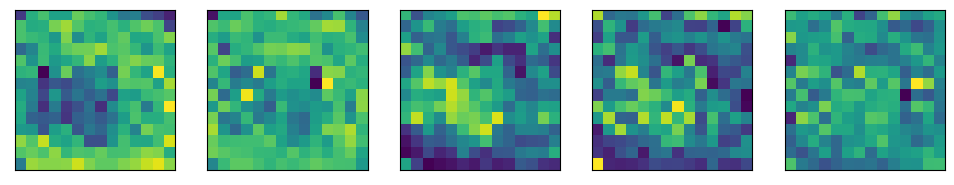

In [28]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, remove from grad tracking, switch to numpy for matplotlib
  axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

In [29]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad  #learnable representation of image created by conv2d layer

(tensor([[[ 0.0615,  0.1236,  0.2564,  0.2705,  0.1458,  0.2886,  0.2608,
            0.2899,  0.0556,  0.2239,  0.1130,  0.0006, -0.0174,  0.0694],
          [ 0.2548,  0.2658,  0.1033,  0.2434,  0.3024,  0.2189,  0.2126,
            0.2113,  0.2317,  0.1817,  0.1271,  0.1192,  0.2923,  0.1460],
          [ 0.3701,  0.2746,  0.1850,  0.2620,  0.2745,  0.1466,  0.2064,
            0.2014,  0.1847,  0.2378,  0.2116,  0.1123,  0.2217,  0.2068],
          [-0.0240,  0.1751,  0.3016,  0.3020,  0.1822,  0.2147,  0.2832,
            0.3063,  0.1526,  0.2951,  0.1807,  0.1532,  0.1560,  0.2064],
          [ 0.2809,  0.1746,  0.2714,  0.2443,  0.1881,  0.2425,  0.2043,
            0.2098,  0.2434,  0.3426,  0.2724,  0.2263,  0.3686,  0.1807],
          [ 0.3094,  0.2157,  0.1858,  0.2473,  0.2159,  0.2452,  0.2102,
            0.2460,  0.1382,  0.1197,  0.2441,  0.2671,  0.3708,  0.1740],
          [ 0.2246,  0.1757, -0.0426,  0.0207,  0.0228,  0.0316,  0.1316,
            0.1851,  0.1151, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've got a series of convolutional feauture maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

**Desried output** (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -> N×(P^2⋅C)  

In [30]:
#768 feature maps of size 14 by 14 
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [31]:
from torch import nn
flatten_layer = nn.Flatten(start_dim = 2, end_dim = 3) # we only want to flatten the "spatial dimensions of the feature map"
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


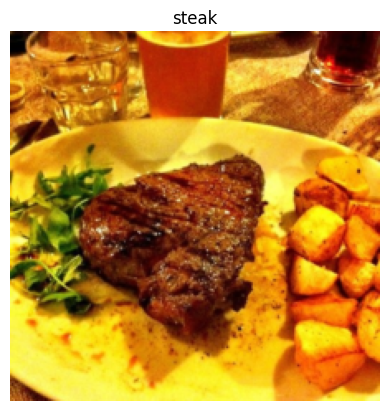

In [32]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [33]:
# Rearrage output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of patches, embedding_dimension)


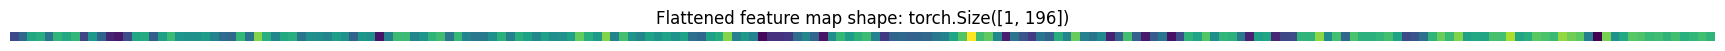

In [34]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map
# 768 flatten embedding vector


# Plot the flattened feature map visually
plt.figure(figsize =(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [35]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0615,  0.1236,  0.2564,  0.2705,  0.1458,  0.2886,  0.2608,  0.2899,
           0.0556,  0.2239,  0.1130,  0.0006, -0.0174,  0.0694,  0.2548,  0.2658,
           0.1033,  0.2434,  0.3024,  0.2189,  0.2126,  0.2113,  0.2317,  0.1817,
           0.1271,  0.1192,  0.2923,  0.1460,  0.3701,  0.2746,  0.1850,  0.2620,
           0.2745,  0.1466,  0.2064,  0.2014,  0.1847,  0.2378,  0.2116,  0.1123,
           0.2217,  0.2068, -0.0240,  0.1751,  0.3016,  0.3020,  0.1822,  0.2147,
           0.2832,  0.3063,  0.1526,  0.2951,  0.1807,  0.1532,  0.1560,  0.2064,
           0.2809,  0.1746,  0.2714,  0.2443,  0.1881,  0.2425,  0.2043,  0.2098,
           0.2434,  0.3426,  0.2724,  0.2263,  0.3686,  0.1807,  0.3094,  0.2157,
           0.1858,  0.2473,  0.2159,  0.2452,  0.2102,  0.2460,  0.1382,  0.1197,
           0.2441,  0.2671,  0.3708,  0.1740,  0.2246,  0.1757, -0.0426,  0.0207,
           0.0228,  0.0316,  0.1316,  0.1851,  0.1151, -0.0260,  0.2023,  0.2920,
           0.236

We've turned single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattened Patches" in Figure 1 of the ViT paper).

### 4.5 Turning the ViT path embedding vector into a PyTorch module

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size. 
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Define `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4).
6. Make sure that the output shape of the layer reflects the required output shape of the patch embedding.

In [36]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
  Args:
      in_channels (int): Number of color channels for the input images. Defaults to 3.
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """ 
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self, 
              in_channels:int = 3,
              patch_size:int = 16, # (for ViT-Base)
              embedding_dim:int = 768): # from Table 1 from ViT-Base
      super().__init__()

      # 3. Create a layer to turn an image into embedded patches
      self.patcher =  nn.Conv2d(in_channels = in_channels, 
                                out_channels = embedding_dim,
                                kernel_size = patch_size,
                                stride = patch_size,
                                padding = 0)
      
      # 4. Create a layer to flatten feature map outputs of Conv2d
      self.flatten = nn.Flatten(start_dim = 2,  # only flatten the feature map dimensions into a single vector
                                end_dim = 3)
      

  # Define a forward method to define the forward computation steps    
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch_size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0, 2, 1)


PatchEmbedding class replicates the patch embedding of the ViT architecture from Figure 1 and Equation 1 from the ViT paper

In [37]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim = 768)

# Pass a single image throught patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [38]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Create class token embedding

Then we need to prepend a learnable class token to the start of the patch embedding.

In [39]:
patch_embedded_image.shape #  -> [batch_size, number_of_patches, embedding_dimension]

torch.Size([1, 196, 768])

We need to create a learnable embedding in the shape of the embedding_dimension (D) and then add it to the number_of_patches dimension.

Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [40]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [41]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [42]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [43]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)         
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_batches, embedding_dim)")                                             

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4455,  0.0254, -0.0375,  ...,  0.3707, -0.1871, -0.2136],
         [-0.5054, -0.0353, -0.1142,  ...,  0.3147, -0.2419,  0.2833],
         ...,
         [-0.6592,  0.0705, -0.1465,  ...,  0.3419, -0.2838,  0.3056],
         [-0.5114,  0.0728, -0.2473,  ...,  0.4808, -0.2925,  0.2827],
         [-0.6211,  0.1471, -0.3050,  ...,  0.4250, -0.2545,  0.3249]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_batches, embedding_dim)


### 4.7 Creating the position embedding 

In this section we are going to create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [44]:
# View the sequence of patch embeddings with the prepended class embedding 
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.4455,  0.0254, -0.0375,  ...,  0.3707, -0.1871, -0.2136],
          [-0.5054, -0.0353, -0.1142,  ...,  0.3147, -0.2419,  0.2833],
          ...,
          [-0.6592,  0.0705, -0.1465,  ...,  0.3419, -0.2838,  0.3056],
          [-0.5114,  0.0728, -0.2473,  ...,  0.4808, -0.2925,  0.2827],
          [-0.6211,  0.1471, -0.3050,  ...,  0.4250, -0.2545,  0.3249]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [45]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True
                                  )
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [46]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5545, 1.0254, 0.9625,  ..., 1.3707, 0.8129, 0.7864],
         [0.4946, 0.9647, 0.8858,  ..., 1.3147, 0.7581, 1.2833],
         ...,
         [0.3408, 1.0705, 0.8535,  ..., 1.3419, 0.7162, 1.3056],
         [0.4886, 1.0728, 0.7527,  ..., 1.4808, 0.7075, 1.2827],
         [0.3789, 1.1471, 0.6950,  ..., 1.4250, 0.7455, 1.3249]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4. 8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings.

Now let's turn it all in one cell.

In [47]:
# Set seed
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels =3, 
                                       patch_size = patch_size,
                                       embedding_dim = 768)
# 5. Pass imput image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedinng shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding 
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim =1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embeddings 
number_of_patches = int((height * width) / patch_size** 2)
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches +1, embedding_dimension),
                                  requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedinng shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attantion to itself?
  * In our case, we have a series of embedded image patches. So, the question is: which patch significantly relates to another patch?
  * We want our neural network (ViT) to learn this relationship/representation. 
* To replicate MSA in PyTorch we can use torch.nn.MultiheadAttention

* LayerNorm = Layer Normalization is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training and better generalization accuracy. 
  * In PyTorch = torch.nn.LayerNorm normalizes values over $D$ dimensions, in our case, the $D$ dimensions is the embedding dimension. 
    * When we normalize along the embedding dimension, it's like making all of the stairs in a staircase the same size. 

In [48]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self-attention block ("MSA block")
  """
  def __init__(self, 
              embedding_dim: int = 768, # hidden size D for ViT-Base
              num_heads: int = 12, # Heads from table 1 
              attn_dropout: int = 0):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
  

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension) 
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x, 
                                         key = x, 
                                         value = x,
                                         need_weights = False)
    return attn_output

In [49]:
# Create an instance block
multi_head_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                              num_heads = 12, 
                                                              attn_dropout = 0)
# Pass the patch and position image embedding sequence through MSA block
patched_image_though_MSA_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_though_MSA_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [50]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5545, 1.0254, 0.9625,  ..., 1.3707, 0.8129, 0.7864],
         [0.4946, 0.9647, 0.8858,  ..., 1.3147, 0.7581, 1.2833],
         ...,
         [0.3408, 1.0705, 0.8535,  ..., 1.3419, 0.7162, 1.3056],
         [0.4886, 1.0728, 0.7527,  ..., 1.4808, 0.7075, 1.2827],
         [0.3789, 1.1471, 0.6950,  ..., 1.4250, 0.7455, 1.3249]]],
       grad_fn=<AddBackward0>)

In [51]:
patched_image_though_MSA_block

tensor([[[-0.1767, -0.3083,  0.0225,  ..., -0.3031,  0.8039, -0.3804],
         [-0.1790, -0.3088,  0.0249,  ..., -0.2948,  0.8109, -0.3912],
         [-0.1750, -0.3044,  0.0280,  ..., -0.2990,  0.8127, -0.3946],
         ...,
         [-0.1759, -0.3031,  0.0267,  ..., -0.2998,  0.8119, -0.3928],
         [-0.1765, -0.3012,  0.0255,  ..., -0.2991,  0.8093, -0.3914],
         [-0.1767, -0.3009,  0.0271,  ..., -0.2986,  0.8121, -0.3924]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity. (section 3. 1). Where "two layers" refers to linear layers (torch.nn.Linear() in PyTorch) and "GELU non-linearity" is the GELU (Gaussian Error Linear Units) non-linear activation function (torch.nn.GELU() in PyTorch). MLP number of hidden units = MLP size in Table 1.
* **Dropout** - Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts (Appendix B.1 (Training)). 
  * Value for Dropout available in Table 3 (for ViT-Base, dropout=0.1). 

The structure of our MLP block is the following:
```python
layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout
```

In [52]:
# Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron block"""
  # Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self, 
               embedding_dim:int = 768, # Hidden Size D from Table 1 for ViT-Base
               mlp_size: int = 3072, # MLP size from Table 1 for ViT-Base
               dropout: int = 0.1): # Dropout from Table 3 for ViT-Base
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size), # project to larger size to hopefully capture more information
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim), # squeeze it back to embed dim
        nn.Dropout(p = dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) benefit from operator fusion

In [53]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim = 768, 
                    mlp_size = 3072,
                    dropout = 0.1)

# Pass output of the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_though_MSA_block)
print(f"Input shape of MLP Block: {patched_image_though_MSA_block.shape}")
print(f"Output shape of MLP Block: {patched_image_through_mlp_block.shape}")

Input shape of MLP Block: torch.Size([1, 197, 768])
Output shape of MLP Block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination alternating blocks of MSA (equation 2) and MLP (equation 3). 

And there are residual connections between each block. Residual connections - add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small).

```python
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

* Encoder - turn a sequence into learnable representation. 
* Decoder - go from learnt representaiton back to some sort of sequence. 



### 7.1 Create a custom Transformer Encoder block

In [54]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self, 
               embedding_dim: int = 768, 
               num_heads: int = 12, # from table 1
               mlp_size: int = 3072, # from table 1
               mlp_dropout: int = 0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
               attn_dropout: int = 0): # Amount of dropout for attention layers
    super().__init__()

    # Create MSA block 
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim, 
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)
    # Create MLP block 
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)
  
  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2 (add the input to the output)
    x = self.mlp_block(x) + x # residual/skip connection for equation 3 (add the input to the output)
    return x

In [55]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block, 
        input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 20, 
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with in-built PyTorch layers

So far we've created a transformer encoder by hand. 

But we can create a Transformer Encoder with pure PyTorch layers.

In [56]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model = 768, # embedding sixe
                                                                   nhead = 12,
                                                                   dim_feedforward = 3072, # MLP size from table
                                                                   dropout = 0.1, 
                                                                   activation = "gelu",
                                                                   batch_first = True,
                                                                   norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [57]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 8. Putting it all together to create ViT

In [58]:
# Create ViT class
class ViT(nn.Module):
  """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
  # Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               img_size: int = 224, # Training resolution from Table 3 in ViT paper
               in_channels: int = 3, # Number of channels in input image
               patch_size: int = 16, # Patch size
               num_transformer_layers: int = 12, # "Layers" for ViT-Base (Table 1)
               embedding_dim: int = 768, # hidden size D for ViT-Base (Table 1) 
               mlp_size: int = 3072, # MLP size for ViT-Base (Table 1) 
               num_heads: int = 12, # Heads for ViT-Base (Table 1) 
               attn_dropout:int = 0, # Dropout for attention projection
               mlp_dropout: int = 0.1, # Dropout for dense/MLP layers
               embedding_dropout: int = 0.1, # Dropout for patch and position embeddings 
               num_classes:int = 1000): # Default for ImageNet
      super().__init__()

      # Make an assertion that the image size is compatible with patch size 
      assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

      # Calculate the number of patches (height * width / patch^2)
      self.num_patches = (img_size * img_size) // patch_size** 2

      # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
      self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                          requires_grad = True)
      
      # Create learnable position embedding
      self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim))

      # Create  embedding dropout value
      self.embedding_dropout = nn.Dropout(p = embedding_dropout) 

      # Create patch emebdding layer
      self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                            patch_size = patch_size, 
                                            embedding_dim = embedding_dim)
      
      # Create the Transformer Encoder block
      self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, 
                                                                         num_heads = num_heads, 
                                                                         mlp_size = mlp_size, 
                                                                         mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])  
      # create a list of 12 TransformerEncoderBlocks and turn this list into its own sequential series of layers using the * parameter, 
      # '*' means all of the layers in this list comprehension turned into sequential, this gives us a way to stack encoders on top of each other

      # Create classifier head
      self.classifier = nn.Sequential(
          nn.LayerNorm(normalized_shape = embedding_dim),
          nn.Linear(in_features = embedding_dim,
                    out_features=num_classes)

      )
  def forward(self, x):
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim = 1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding 
    x = self.position_embedding + x

    # Apply dropout to patch embeddings "directly after adding positional- to patch embeddings. "
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (equation 2 & 3) 
    x = self.transformer_encoder(x)
    print(x.shape)

    # Put the 0th index logit through the classifier (equation 4)
    x = self.classifier(x[:, 0,:])
    print(x[:,0].shape)

    return x

In [59]:
batch_size = 32
embedding_dim = 768
# Create learnable class embedding (needs to go at front of sequence of patch embeddings)
class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                          requires_grad = True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [60]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes = len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

torch.Size([1, 197, 768])
torch.Size([1])


tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our model

In [61]:
from torchinfo import summary
summary(model = ViT(num_classes = len(class_names)), 
        input_size = (1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 20, 
        row_settings = ["var_names"])

torch.Size([1, 197, 768])
torch.Size([1])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

The total number of parameters is 85,800,963. The number is very close to PyTorch's pretrained ViT-Base with patch size 16 at `torch.vision.models.vit_b_16()` with 86,567,656 total parameters (though this number of parameters is for the 1000 classes in ImageNet).

## 9. Setting up training code for our custom ViT

We have replicated the ViT architecture, now let's see how it performs on our FoodVision problem.

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ value of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights to the loss function. 

Regularization technique prevents overfitting.

We'll set the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).



## 9.2 Creating a loss function

The ViT paper doesn't mention what loss function they used. 

So since it's a multi-class classification we will use the `torch.nn.CrossEntropyLoss()`.

### 9.3 Training our ViT Model

In [62]:
from scripts import engine


# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(vit.parameters(), 
                             lr = 3e-3,  # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas = (0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay = 0.1) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader, 
                       epochs = 10, 
                       optimizer = optimizer,
                       loss_fn = loss_fn, 
                       device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 10%|█         | 1/10 [00:03<00:33,  3.67s/it]

Epoch: 1 | train_loss: 6.3057 | train_acc: 0.2227 | test_loss: 2.1622 | test_acc: 0.2604
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 20%|██        | 2/10 [00:06<00:26,  3.28s/it]

Epoch: 2 | train_loss: 1.8090 | train_acc: 0.3828 | test_loss: 2.3391 | test_acc: 0.2604
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 30%|███       | 3/10 [00:09<00:22,  3.16s/it]

Epoch: 3 | train_loss: 1.5752 | train_acc: 0.3125 | test_loss: 1.8619 | test_acc: 0.2604
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 40%|████      | 4/10 [00:12<00:18,  3.14s/it]

Epoch: 4 | train_loss: 1.4906 | train_acc: 0.2891 | test_loss: 1.4324 | test_acc: 0.1979
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 50%|█████     | 5/10 [00:15<00:15,  3.12s/it]

Epoch: 5 | train_loss: 1.3190 | train_acc: 0.2891 | test_loss: 1.1660 | test_acc: 0.2604
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 60%|██████    | 6/10 [00:18<00:12,  3.10s/it]

Epoch: 6 | train_loss: 1.1418 | train_acc: 0.3047 | test_loss: 1.7148 | test_acc: 0.1979
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 70%|███████   | 7/10 [00:21<00:09,  3.08s/it]

Epoch: 7 | train_loss: 1.1517 | train_acc: 0.4414 | test_loss: 1.5430 | test_acc: 0.1979
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 80%|████████  | 8/10 [00:25<00:06,  3.06s/it]

Epoch: 8 | train_loss: 1.1286 | train_acc: 0.4219 | test_loss: 1.3829 | test_acc: 0.2604
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


 90%|█████████ | 9/10 [00:28<00:03,  3.05s/it]

Epoch: 9 | train_loss: 1.2161 | train_acc: 0.3008 | test_loss: 1.0453 | test_acc: 0.5417
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([1, 197, 768])
torch.Size([1])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([32, 197, 768])
torch.Size([32])
torch.Size([11, 197, 768])
torch.Size([11])


100%|██████████| 10/10 [00:31<00:00,  3.10s/it]

Epoch: 10 | train_loss: 1.2134 | train_acc: 0.3047 | test_loss: 1.4211 | test_acc: 0.2604


Even though our ViT architecture is the same as the paper, the results we get aren't as good.
There are several reasons for this, but the most important are use of a far larger amount of data than ours and a longer training schedule.

Number of training images in ViT paper - 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT), while in our implementation - 225. 

The number of epochs in ViT paper - 7 (for largest dataset), 90, 300 (for ImageNet), while in our implementation - 10.

### 9.4 What our training set up is missing?

How is our training setup diffrent from ViT paper?

The main thing our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warm up - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevents gradients from getting too big

### 9.5 Plotting loss curves for our model

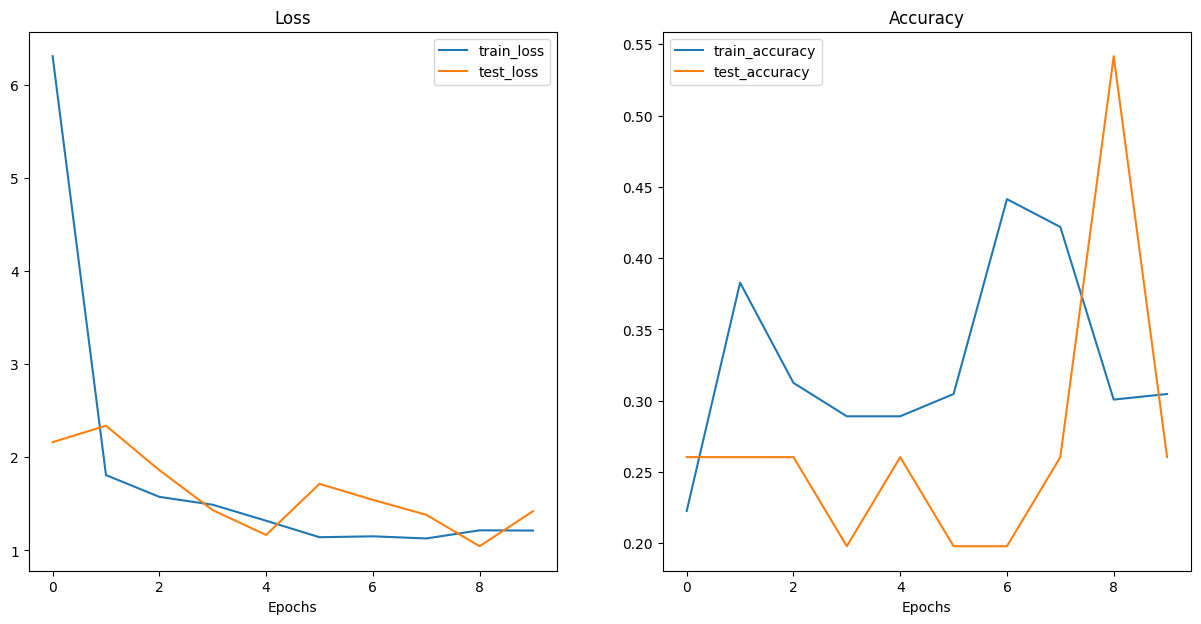

In [63]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

It looks like loss is heading the right direction but the accuracy curves don't really show much promise. These results are likely because of the difference in data resources and training regime of our ViT model versus the ViT paper.

It seems our model is severly underfitting.

Let's try to fix it by bringing in a pretrained ViT model.

## 10. Using a pretrained ViT from `torchvision.models`

### 10.1 Why use pretrained models?

Why use a pretrained model?
* Sometimes data is limited
* Limited training resources
* Get better results faster

In [72]:
import torch
import torchvision

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision (turn it into feature extractor)

In [74]:
# Get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # default - best available

# Setup a ViT model instance with pretrained weights and send it to the target device
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False # gradients don't update during training

# Update the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features = 3).to(device)

In [75]:
summary(model = pretrained_vit, 
        input_size = (32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 20, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

We can see that only the output layer is trainable, while other layers are frozen. 
The total number of parameters (85,800,963) is the same as our custom made ViT model. But the number of trainable parameters for pretrained_vit is much lower than custom ViT at only 2,307 compared to 85,800,963.

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, we need to make sure that data is formatted in the same way that the model was trained on. 

In [76]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [77]:
from scripts import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir, 
                                                                                                     test_dir = test_dir, 
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size = 32
                                                                                                     ) 

### 10.4 Train feature extractor ViT model

In [78]:
from scripts import engine

# Create optimizer
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                             lr = 3e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit, 
                                      train_dataloader = train_dataloader_pretrained, 
                                      test_dataloader = test_dataloader_pretrained, 
                                      optimizer = optimizer, 
                                      loss_fn = loss_fn, 
                                      epochs = 10,
                                      device = device)


 10%|█         | 1/10 [00:02<00:18,  2.05s/it]

Epoch: 1 | train_loss: 0.5048 | train_acc: 0.8047 | test_loss: 0.2507 | test_acc: 0.9186


 20%|██        | 2/10 [00:04<00:16,  2.02s/it]

Epoch: 2 | train_loss: 0.1300 | train_acc: 0.9609 | test_loss: 0.1858 | test_acc: 0.9176


 30%|███       | 3/10 [00:06<00:14,  2.05s/it]

Epoch: 3 | train_loss: 0.0835 | train_acc: 0.9727 | test_loss: 0.2105 | test_acc: 0.9176


 40%|████      | 4/10 [00:08<00:12,  2.06s/it]

Epoch: 4 | train_loss: 0.0508 | train_acc: 0.9844 | test_loss: 0.2194 | test_acc: 0.8873


 50%|█████     | 5/10 [00:10<00:10,  2.06s/it]

Epoch: 5 | train_loss: 0.0312 | train_acc: 0.9922 | test_loss: 0.2099 | test_acc: 0.9176


 60%|██████    | 6/10 [00:12<00:08,  2.05s/it]

Epoch: 6 | train_loss: 0.0276 | train_acc: 0.9961 | test_loss: 0.2027 | test_acc: 0.9176


 70%|███████   | 7/10 [00:14<00:06,  2.07s/it]

Epoch: 7 | train_loss: 0.0173 | train_acc: 1.0000 | test_loss: 0.2239 | test_acc: 0.8977


 80%|████████  | 8/10 [00:16<00:04,  2.10s/it]

Epoch: 8 | train_loss: 0.0134 | train_acc: 1.0000 | test_loss: 0.2215 | test_acc: 0.9081


 90%|█████████ | 9/10 [00:18<00:02,  2.10s/it]

Epoch: 9 | train_loss: 0.0140 | train_acc: 1.0000 | test_loss: 0.2129 | test_acc: 0.9384


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

Epoch: 10 | train_loss: 0.0102 | train_acc: 1.0000 | test_loss: 0.2039 | test_acc: 0.9176


As expected, pretrained ViT feature extractor performed much better than our custom ViT model trained from scratch.

### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

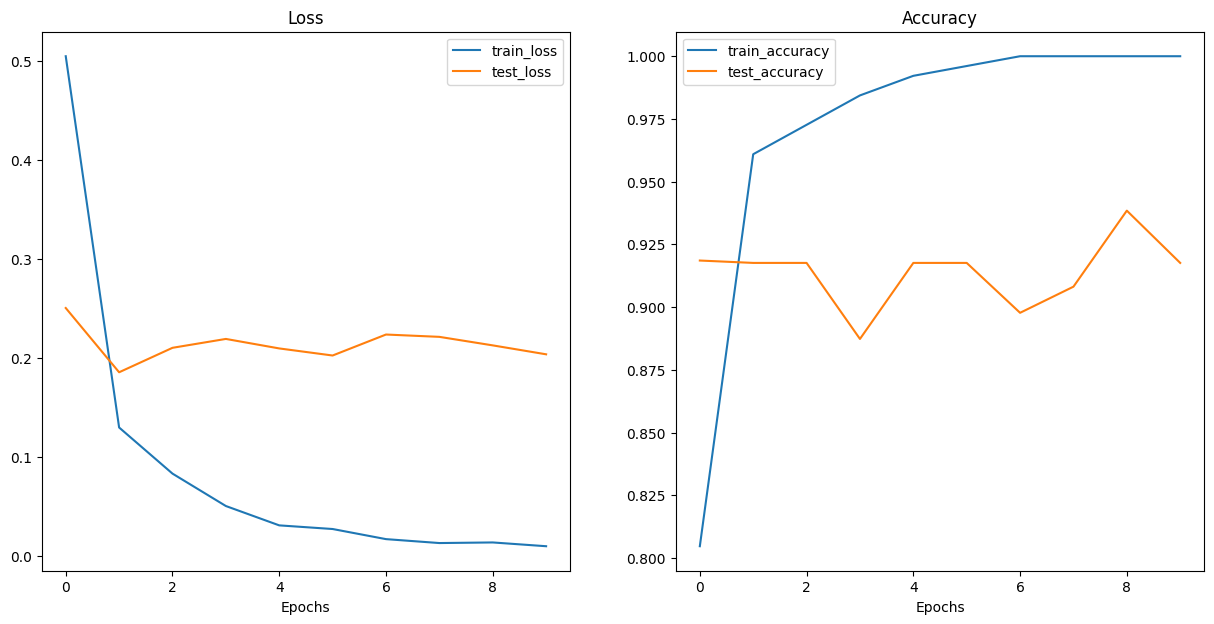

In [79]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

The Loss and Accuracy plots look much better than those related to the custom ViT (loss gradually decreases and accuracy increases).

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well. We can save it to file and then check its file size.

Because if we want to deploy a model to website/mobile application, we may have limitations on the size of the model we can deploy.

E. g. smaller model may be required due to compute restrictions. 

In [80]:
from scripts.helper_functions import save_model

save_model(model = pretrained_vit,
                 target_dir = "models", 
                 model_name = "pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [81]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## 11. Predicting on a custom image

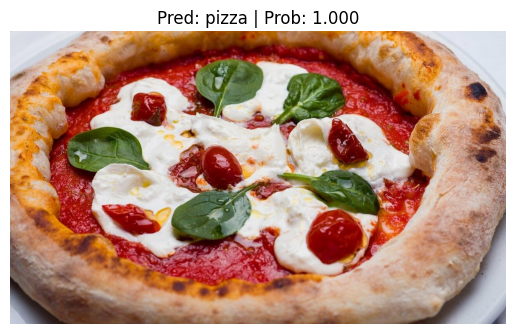

In [82]:
import requests

# Import function to make predictions on images and plot them 
from scripts.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "neapolitan_pizza.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/vic-art/ViT_paper_replicating/raw/main/custom_images/neapolitan_pizza.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)